In [ ]:
!pip install spacy

In [1]:
## Load data

import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from collections import Counter
from nltk.tokenize import  word_tokenize
import pickle
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load

2023-05-23 21:06:16.249643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 21:06:22.226582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-23 21:06:22.226993: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
%%time

df_news = pd.read_parquet('02_clean_df.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 40s, sys: 10.6 s, total: 1min 51s
Wall time: 1min 25s


(198564, 7)

In [5]:
df_news['clean_text_sent'] = df_news['clean_text'].apply(lambda words: ' '.join(words))

In [6]:
df_news.sample(3)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent
123658,2023-03-15,OpenAI releases latest version of artificial.....,OpenAI releases latest version of artificial.....,2023-03,"[OpenAI, release, latest, version, artificial,...","[openai, release, latest, version, artificial,...",openai release latest version artificial daily...,openai release latest version artificial daily...
76722,2022-07-06,"Celus, which uses AI to automate circuit board...","Celus, which uses AI to automate circuit board...",2022-07,"[Celus, us, AI, automate, circuit, board, desi...","[celus, us, ai, automate, circuit, board, desi...",celus us ai automate circuit board design rais...,celus us ai automate circuit board design rais...
94598,2021-01-29,Use Azure Backup for Active Directory forest r...,\n\nUse Azure Backup for Active Directory fore...,2021-01,"[Use, Azure, Backup, Active, Directory, forest...","[use, azure, backup, active, directory, forest...",use azure backup active directory forest recov...,use azure backup active directory forest recov...


### Most Frequent Terms in our clean data

In [10]:
from nltk import FreqDist

# Assuming you have a DataFrame called 'df' and the column name is 'tokens'
all_tokens = [token for sublist in df_news['clean_text'] for token in sublist]

# Calculate the frequency distribution
freq_dist = FreqDist(all_tokens)

# Get the top 20 most frequent tokens
top_20_tokens = freq_dist.most_common(20)

# Print the top 20 tokens
for token, frequency in top_20_tokens:
    print(token, frequency)


ai 1763902
market 1431503
news 932503
data 714555
intelligence 677457
us 670017
new 654088
technology 639206
artificial 608100
business 588721
company 554645
report 519670
global 471869
industry 420743
research 387129
analysis 377434
said 334892
also 319732
learning 316282
growth 312685


## Customised Sentiment Analysis

### Using Logistic Regression on Yelp review data

In [7]:
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

In [8]:
%%time

yelp = pd.read_json(path, orient='records', lines=True)
yelp.shape

CPU times: user 2.38 s, sys: 827 ms, total: 3.21 s
Wall time: 3.71 s


(255717, 3)

In [9]:
pd.set_option('display.max_colwidth', 200)

In [10]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255717 entries, 0 to 255716
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    255717 non-null  object
 1   label   255717 non-null  int64 
 2   lang    255717 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.9+ MB


In [11]:
yelp.nunique()

text     255649
label         2
lang          1
dtype: int64

In [12]:
# define X and y
X = yelp['text']
y = yelp['label']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (255717,)
y Shape: (255717,)


In [13]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (191787,) y_train: (191787,)
Testing records, X_test: (63930,) y_test: (63930,)


### Initializing the Pipeline 

In [14]:
logreg_pipeline = make_pipeline(
    CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    SGDClassifier(max_iter=100, tol=None)
)

### Building and Evaluating Models

In [15]:
%time logreg_pipeline.fit(X_train, y_train)

CPU times: user 3min 54s, sys: 5.47 s, total: 3min 59s
Wall time: 3min 57s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('sgdclassifier', SGDClassifier(max_iter=100, tol=None))])

In [16]:
y_pred = logreg_pipeline.predict(X_test)
print("Accuracy : ",round(metrics.accuracy_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

Accuracy :  0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32003
           1       0.97      0.97      0.97     31927

    accuracy                           0.97     63930
   macro avg       0.97      0.97      0.97     63930
weighted avg       0.97      0.97      0.97     63930



In [17]:
%time dump(logreg_pipeline, "logreg_large.joblib")

CPU times: user 1min 20s, sys: 1.72 s, total: 1min 21s
Wall time: 1min 22s


['logreg_large.joblib']

### Running the Yelp Trained Model on News data

In [18]:
%time clf_large = load('logreg_large.joblib')

CPU times: user 38.6 s, sys: 1.6 s, total: 40.2 s
Wall time: 40.2 s


In [19]:
%time pred_sentiment = clf_large.predict(df_news['clean_text_sent'])
sent_class = np.where(pred_sentiment < 1, 'Negative', 'Positive')

CPU times: user 5min 19s, sys: 937 ms, total: 5min 19s
Wall time: 5min 19s


In [20]:
df_news['sentiment_text'] = sent_class
df_news['sentiment_text_score'] = pred_sentiment

In [21]:
df_news['sentiment_text'].value_counts()

Negative    166887
Positive     31677
Name: sentiment_text, dtype: int64

In [22]:
%time pred_sentiment_title = clf_large.predict(df_news['clean_title'])
sent_class_title = np.where(pred_sentiment_title < 1, 'Negative', 'Positive')

CPU times: user 5.64 s, sys: 3.73 ms, total: 5.64 s
Wall time: 5.64 s


In [23]:
df_news['sentiment_title'] = sent_class_title
df_news['sentiment_title_score'] = pred_sentiment_title

In [26]:
df_news['sentiment_title'].value_counts()

Negative    166484
Positive     32080
Name: sentiment_title, dtype: int64

In [27]:
#saving with sentiment
df_news.to_parquet('03_sent_logreg_df.parquet')

In [28]:
print('Total number of rows: ',df_news.shape[0])

## Dropping duplicate news articles
df1 = df_news.drop_duplicates(subset=['clean_text_sent'], keep='first', inplace=False)
print('Drop text dups: ',df1.shape[0])

## Dropping news titles that report articles with the same sentiment
df2 = df1.drop_duplicates(subset=['title','sentiment_text'], keep='first', inplace=False)
print('Drop title, sentiment dups: ',df2.shape[0])

Total number of rows:  198564
Drop text dups:  197812
Drop title, sentiment dups:  141418


In [29]:
df2['sentiment_text'].value_counts()

Negative    120636
Positive     20782
Name: sentiment_text, dtype: int64

In [31]:
import pandas as pd



# Group the DataFrame by 'year_month' and 'sentiment_label', and calculate the counts
grouped = df2.groupby(['year_month', 'sentiment_text']).size().unstack(fill_value=0)

# Convert the grouped data to separate lists for positive, negative, and neutral sentiments
timeline = grouped.index.astype(str).tolist()
positive_sentiment = grouped['Positive'].tolist()
negative_sentiment = grouped['Negative'].tolist()


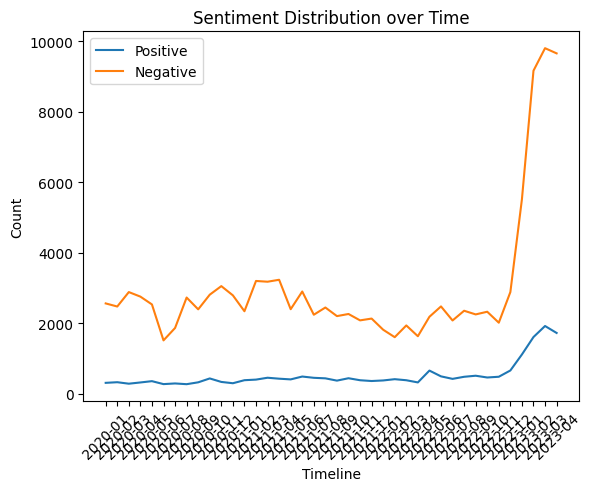

In [32]:

# Line plot
plt.plot(timeline, positive_sentiment, label='Positive')
plt.plot(timeline, negative_sentiment, label='Negative')
#plt.plot(timeline, neutral_sentiment, label='Neutral')
plt.xlabel('Timeline')
plt.ylabel('Count')
plt.title('Sentiment Distribution over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [24]:
df_pos = df2[df2['sentiment_text'] == 'Positive']
df_neg = df2[df2['sentiment_text'] == 'Negative']

In [26]:
#saving with sentiment
df_pos.to_parquet('04_pos_df.parquet')
df_neg.to_parquet('05_neg_df.parquet')

## Zero Shot Classification

In [4]:
%%time

df_news = pd.read_parquet('03_sent_df.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 23s, sys: 18.3 s, total: 1min 41s
Wall time: 1min 35s


(198564, 10)

In [30]:
from transformers import pipeline
import pandas as pd

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")


No model was supplied, defaulted to roberta-large-mnli and revision 130fb28 (https://huggingface.co/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


2023-05-20 22:49:38.923935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [34]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
%%time

from tqdm import tqdm

# Define the candidate labels
candidate_labels = ["technology", "non-technology"]

# Function to classify a single news text
def classify_text(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0]

tqdm.pandas()

# Apply the classification to the dataframe
df2['zsc_topic'] = df2['clean_title'].progress_apply(classify_text)

# Print the dataframe
print(df2)

In [ ]:
df2['zsc_topic'].value_counts()